 # Creating a real-time fraud detection machine learning application applied to Minecraft


## 1 - Thoughts and Motives

### 1.1 - Definition
Cheating in Minecraft has been here since its release. Many people tried to detect different types of hacks/frauds throughout the years. However, cheat developers found always found their way around anti-fraud measures put on by servers.

### 1.2 - Idea
The idea of this project is to try and see if we use machine learning to detect a certain type of fraud, in this case "autoclicking". Autoclicking is the process of creating human-like click patterns and sending them to the game in order to gain an unfair advantage over another player.


## 2 - Datasets and Algorithms

### 2.1 - Dataset
While there a not any dataset available for this kind of research, we will build our own. The dataset will be built as the following:

- Collect **real** human data using mouse inputs.
- Use multiple **algorithms** from known autoclick softwares to create human-like sequences.

The data will consist of one column containing the delay $$ \Delta D $$ ellapsed between each mouse click, defined like:
$$
\Delta D = r - p
$$
**p**being the point in  time where the left mouse button have been pressed.

**r** being the point in time where the left mouse button have been released.

In this notebook we won't focus on the data collection part but rather on the process of analysing it.

### 2.2 ML Algorithms

While researching the differents ways of knowing if a player is clicking manually or if he's using an autoclicker, I first thought that it's like finding values in a dataset that shoudln't belong here. To better understand we need to know how a player behave when fighting an opponent in Minecraft.

The most popular method to maximize chances of gaining an advantage over you opponent is jitterclicking.

*Jitter clicking is the technique of contracting your hand/arm in order to produce little shaking movements resulting in clicking rapidly.*

While the delays generated using jitterclicking seems random at first, there are some features that this method has which makes it unique like **muscle fatigue** or inconsistancy that leads to **spikes** or **drops** in the clicking speed. Thoe features make it harder to mimic using a algorithm and it is this particularity that we will try to exploit.

### 2.3 - Isolation Forest

[Isolation Forest by Fei Tony Liu, Kai Ming Ting](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf)

Now that we know how jitter-clicking work, the first way we want to detect if a sequence of clicks are human or not is by finding anomalies in the data set, values that a human generated sequence won't contain. The most appropriate algorithm for this experiment is the Isolation Forest. IForest is made to detect anomalies, IForest have been proven to have a better AUC and processing time over LOF, Random Forests and ORCA. Futhermore, IForest performs better with a small sample/sub-sample (typcally 2^8 or 256 as stated in the original paper). This is a good point considering that nowadays, most fraud detections on Minecraft happens server-side, so IForest needing small samples and using little RAM is great.








## 3 - Implementation

Now that we know what our data set looks like and which algorithm we want to use, we can start to implement our idea.

### 3.1 - Analyzing our dataset

In [7]:
import numpy as np
import pandas as pd
import os
print(os.listdir('input'))
df = pd.read_csv('input/click_data_low.csv')
print(df.describe())
df.head()

['click_data.csv', 'click_data1695511074461.csv', 'click_data_low.csv']
           clicks
count  100.000000
mean    90.080000
std     12.659232
min      0.000000
25%     88.000000
50%     89.000000
75%     96.000000
max    112.000000


,clicks
0,0.0
1,63.0
2,86.0
3,80.0
4,88.0


As we can see this dataset is pretty small, but as we saw, this is not really a problem with IForest. Now let's try to visualize our dataset on a scatterpoint.


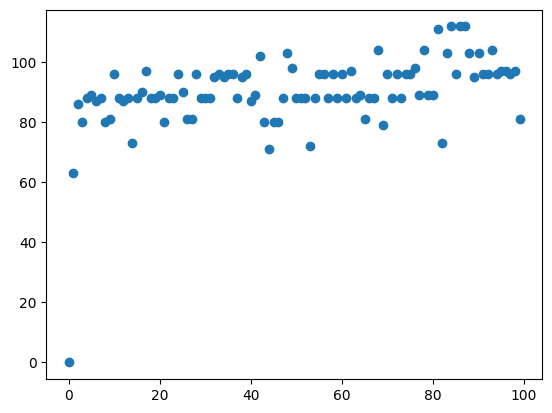

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.scatter(df.index, df["clicks"])

plt.show()

This plot can help us see the differents behaviors of human jitter-clicking.

### 3.2 Training our model

Now that we looked at our dataset, we can start using IForest.

In [10]:
from sklearn.ensemble import IsolationForest

def build(data, contamination='auto') -> pd.DataFrame:
    model = IsolationForest(contamination=contamination) # we set contamniation to auto
    model.fit(data)
    preds_data = {"anomaly": []}
    metrics_df = pd.DataFrame(preds_data)
    metrics_df["anomaly"] = model.predict(data_array)
    return metrics_df


data_array = np.array(df['clicks']).reshape(-1, 1)

result_df = build(data_array)

print(result_df['anomaly'].value_counts())





anomaly
 1    78
-1    22
Name: count, dtype: int64


Let's try to plot the data again but with a different color for each class


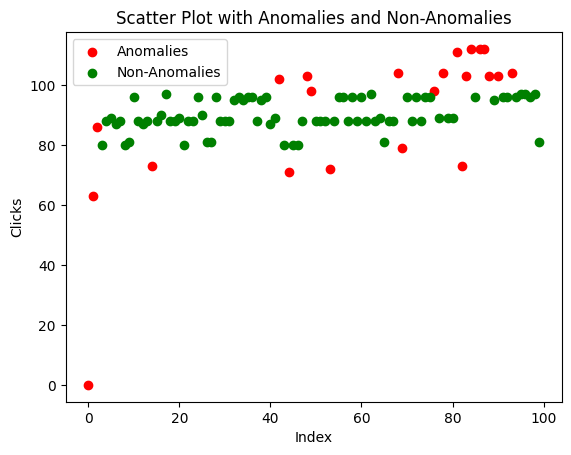

In [11]:
# Scatter plot with anomalies (-1) in red and non-anomalies in green
plt.scatter(df.index[result_df['anomaly'] == -1], df['clicks'][result_df['anomaly'] == -1], color='red', label='Anomalies')
plt.scatter(df.index[result_df['anomaly'] != -1], df['clicks'][result_df['anomaly'] == 1], color='green', label='Non-Anomalies')

plt.xlabel('Index')
plt.ylabel('Clicks')
plt.title('Scatter Plot with Anomalies and Non-Anomalies')
plt.legend()
plt.show()